In [1]:
import sys
sys.path.append('..')
from CuriousAFL.rnd import RND
import os
import numpy as np
import torch
import seaborn as sb
import random
from tqdm import tqdm
from collections import deque

# epochs are controlled by AFL
retrain_every_x_seeds = 5

max_filesize = 2**12
out_size = 2**6
learning_rate = 1e-4

rnd_model = None
#random sample of files to retrain model

input_dim = max_filesize
output_dim = 2 #fuzz or don't - 2 possible actions

batch_size = 128 # TODO: WHY?
replay_buffer = deque(maxlen=64) 


In [10]:
8*max_filesize

131072

In [4]:
seed_dir = '/home/david/Documents/gits/fuzztestbench/objdump-afl/afl_out/queue/'
seeds = os.listdir(seed_dir)

In [3]:

def vectorize(input_file):

    shape = np.zeros(shape=(max_filesize, 8))

    with open(input_file, "rb") as f:
        byte = f.read(1)
        byte_pos = 0
        print(byte)
        while byte:
            bits = bin(int.from_bytes(byte, byteorder="big"))[2:].zfill(8)
           
            for n, bit in enumerate(bits):
                if bit == '1':
                    shape[byte_pos, n] = 1.
            break
            byte = f.read(1)
            byte_pos += 1

    return shape


In [5]:
from mmap import ACCESS_READ, mmap

with open('./initial_seeds/' + seeds[0], 'rb', 0) as f, mmap(f.fileno(), 0, access=ACCESS_READ) as s:
    arr = s

FileNotFoundError: [Errno 2] No such file or directory: './initial_seeds/id:000073,src:000000,op:flip1,pos:357,+cov'

In [4]:
rnd_model = RND(in_dim=input_dim, out_dim=64, n_hid=int(input_dim/8))

In [5]:
rnd_model.target

NN(
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=64, bias=True)
  (softmax): Softmax(dim=1)
)

In [9]:
byte_array = np.fromfile(seed_dir + seeds[0], 'u1')
bit_array = np.unpackbits(byte_array)
len(bit_array)

58432

In [51]:
%load_ext heat

The heat extension is already loaded. To reload it, use:
  %reload_ext heat


100%|██████████| 1000/1000 [10:11<00:00,  1.64it/s]


611.3607919216156
181.48804306983948


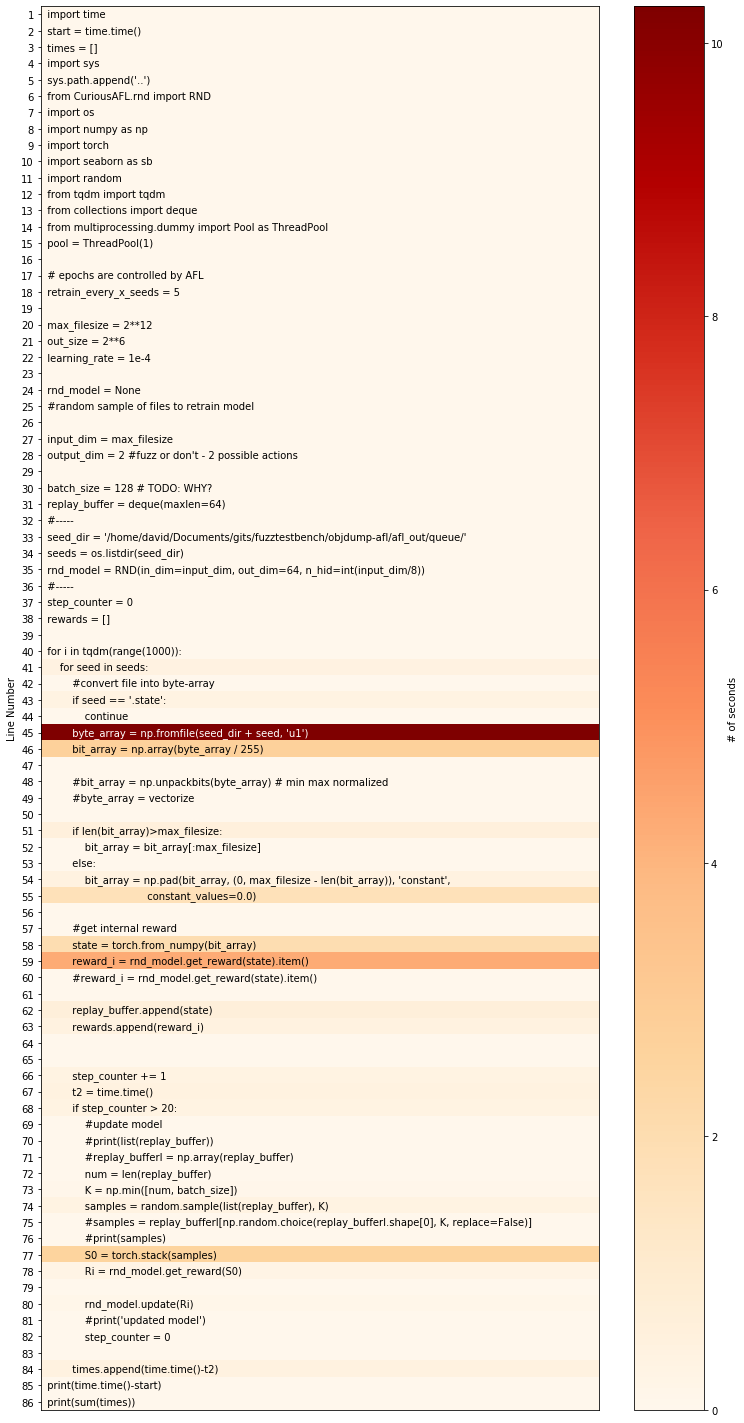

In [54]:
%%heat  
import time
start = time.time()
times = []
import sys
sys.path.append('..')
from CuriousAFL.rnd import RND
import os
import numpy as np
import torch
import seaborn as sb
import random
from tqdm import tqdm
from collections import deque
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(1) 

# epochs are controlled by AFL
retrain_every_x_seeds = 5

max_filesize = 2**12
out_size = 2**6
learning_rate = 1e-4

rnd_model = None
#random sample of files to retrain model

input_dim = max_filesize
output_dim = 2 #fuzz or don't - 2 possible actions

batch_size = 128 # TODO: WHY?
replay_buffer = deque(maxlen=64) 
#-----
seed_dir = '/home/david/Documents/gits/fuzztestbench/objdump-afl/afl_out/queue/'
seeds = os.listdir(seed_dir)
rnd_model = RND(in_dim=input_dim, out_dim=64, n_hid=int(input_dim/8))
#-----
step_counter = 0
rewards = []

for i in tqdm(range(1000)):
    for seed in seeds:
        #convert file into byte-array
        if seed == '.state':
            continue
        byte_array = np.fromfile(seed_dir + seed, 'u1')
        bit_array = np.array(byte_array / 255)

        #bit_array = np.unpackbits(byte_array) # min max normalized
        #byte_array = vectorize

        if len(bit_array)>max_filesize:
            bit_array = bit_array[:max_filesize]
        else:
            bit_array = np.pad(bit_array, (0, max_filesize - len(bit_array)), 'constant', 
                                constant_values=0.0)

        #get internal reward
        state = torch.from_numpy(bit_array)
        reward_i = rnd_model.get_reward(state).item()
        #reward_i = rnd_model.get_reward(state).item()

        replay_buffer.append(state)
        rewards.append(reward_i)


        step_counter += 1
        t2 = time.time()
        if step_counter > 20:
            #update model
            #print(list(replay_buffer))
            #replay_bufferl = np.array(replay_buffer)
            num = len(replay_buffer)
            K = np.min([num, batch_size])
            samples = random.sample(list(replay_buffer), K)
            #samples = replay_bufferl[np.random.choice(replay_bufferl.shape[0], K, replace=False)]
            #print(samples)
            S0 = torch.stack(samples)
            Ri = rnd_model.get_reward(S0)

            rnd_model.update(Ri)
            #print('updated model')
            step_counter = 0

        times.append(time.time()-t2)
print(time.time()-start)
print(sum(times))

In [107]:
reward_buffer = deque(maxlen=10000)

In [108]:
reward_buffer.append(10000*[3012])

In [113]:
%timeit np.percentile(np.array(reward_buffer), [50])[0]

522 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [114]:
%timeit np.percentile(list(reward_buffer), [50])[0]

534 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
num = len(replay_buffer)
K = np.min([num, batch_size])
samples = np.random.choice(replay_buffer, K)

ValueError: a must be 1-dimensional

In [13]:
len(replay_buffer)

0

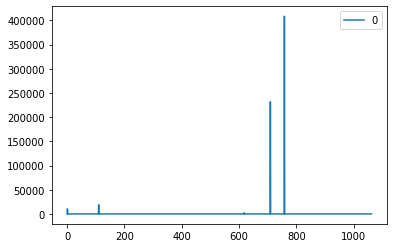

In [9]:
import pandas as pd
df = pd.DataFrame(rewards)
sb.lineplot(data=df)

In [14]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.1 GB


In [13]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [11]:
len(np.fromfile('./initial_seeds/' + seeds[0], 'u1'))

7304

In [45]:
byte_array = np.fromfile('./initial_seeds/' + seeds[0], 'u1')
byte_array

array([127,  69,  76, ...,   0,   0,   0], dtype=uint8)

In [9]:
import os
import numpy as np

In [19]:
path = '/home/david/Documents/gits/CuriousAFL/test/nm-afl/afl_out/queue/'
seeds = os.listdir(path)

In [20]:
maxlen=0

In [21]:
for seed in seeds:
    if seed != ".state":
        byte_array = np.fromfile(os.path.join(path,seed), 'u1')
        if len(byte_array) > maxlen:
            maxlen = len(byte_array)

In [22]:
maxlen

54686

In [24]:
2**14

16384

In [28]:
2 ** 8

256